In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from utils import *

In [2]:
%%time
dataset = get_dataset()

CPU times: user 35.6 s, sys: 441 ms, total: 36.1 s
Wall time: 36.7 s


In [3]:
dataset.head()

,id,t,h,entailment,task,w_overlap,w_hyp_extra,w_jaccard,w_jaccard_s,ne_overlap,ne_hyp_extra,t_negations,h_negations
0,3,"ECB spokeswoman, Regina Schueller, declined to...",Regina Shueller works for Italy's La Repubblic...,CONTRADICTS,IE,5,2,0.172414,0.714286,2,1,0,0
1,4,"Meanwhile, in an exclusive interview with a TI...","Ahmedinejad was attacked by the US, France, Br...",UNRELATED,IE,4,1,0.121212,0.800000,4,0,0,0
2,11,The chaotic situation unleashed in Bogota last...,Justice Carlos Valencia was killed on 28 July.,CONTRADICTS,IE,5,1,0.172414,0.833333,2,0,0,0
3,12,"He met U.S. President, George W. Bush, in Wash...",Washington is part of London.,UNRELATED,IE,2,0,0.133333,1.000000,2,0,0,0
4,13,Sunday's earthquake was felt in the southern I...,The city of Madras is located in Southern India.,AGREE,IE,4,1,0.142857,0.800000,1,1,0,0


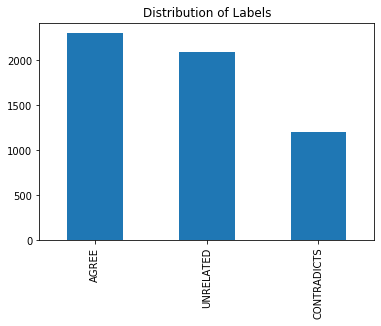

In [4]:
ax = dataset['entailment'].value_counts().plot(kind='bar')
ax.set_title("Distribution of Labels")
plt.show()

### Test Selected Classifier 

In [60]:
np.random.seed(42)
train, test = train_test_split(dataset, stratify=dataset['entailment'], test_size=0.5)

In [61]:
train_test_split

<function sklearn.model_selection._split.train_test_split(*arrays, **options)>

In [62]:
clf = LogisticRegression(random_state=0, multi_class='ovr', solver='lbfgs', max_iter=1000)

clf.fit(train[feat_cols], train['entailment'])  
y_pred = clf.predict(test[feat_cols])
precision, recall, fscore, _ = precision_recall_fscore_support(test['entailment'], y_pred)
print("Precision: {} \tRecall: {}\tF1-Score: {} \tMean Accuracy: {}".format(precision.mean(), 
                                                                            recall.mean(), 
                                                                            fscore.mean(), 
                                                                            round(clf.score(test[feat_cols],
                                                                                            test['entailment']), 4)))

Precision: 0.548131218849112 	Recall: 0.5067236463809167	F1-Score: 0.5033417379607908 	Mean Accuracy: 0.5595


### Plot Confusion Matrix

In [63]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(
    y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues
):
    """
    Taken from https://scikit-learn.org/stable/auto_examples/model_selection/
    plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        title = "Confusion matrix"

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    fig.tight_layout()
    return ax


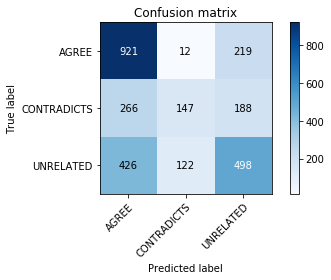

In [64]:
a = plot_confusion_matrix(test['entailment'], y_pred, clf.classes_, normalize=False)

### Testing different classifiers

In [78]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LogisticRegression(random_state=0, multi_class='ovr', solver='lbfgs', max_iter=1000),
    MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0)
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, train[feat_cols], train['entailment'], scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

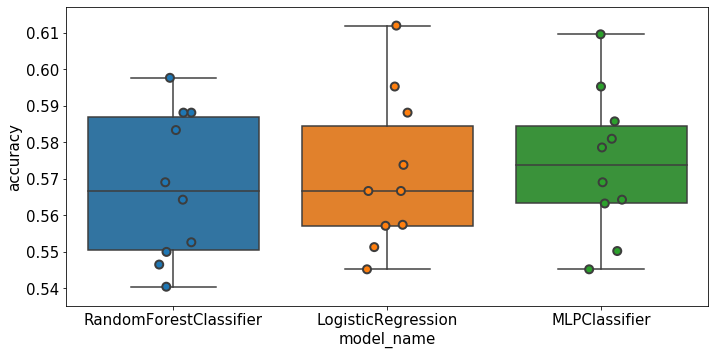

In [79]:
plt.rcParams.update({'font.size': 15})

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

fig = plt.gcf()
fig.set_size_inches(11.5, 5.5)
plt.show()

### Test Interface

In [109]:
import requests

url = 'http://127.0.0.1:5000/'

params ={'text': 'The car ran over the brick road', 
         'hyp': 'I do not like Google'}
response = requests.get(url, params)
response.json()


{'prediction': 'UNRELATED', 'confidence': 0.798}

In [101]:
params ={'text': 'My car drove on the brick road', 
         'hyp': 'I ran over the brick road with the car'}
response = requests.get(url, params)
response.json()

{'prediction': 'AGREE', 'confidence': 0.531}

In [107]:
params ={'text': 'I wished I went base-jumping because I really love heights', 
         'hyp': 'I would never go base-jumping because I do not like heights'}
response = requests.get(url, params)
response.json()

{'prediction': 'CONTRADICTS', 'confidence': 0.579}